data S is sized (N,T), meaning 500 timepoints and 50 neurons.
hd_sim is sized (N,2), meaning 500 timepoints two head dirs.
N = 50, T = 500.

empty estDir of size(2,500)

then run for loop over size of llvals(30):
    for each of them run concurrent futures with "results = list(executor.map(getscorepp, S, [DD]*N))"
can getscorepp be called with there sizes?

assuming results is a list of optimize results. then res.x is 5 numbers.
then params should be (N,5).







In [25]:
def rotateanglestoalign(DDtry, correctangles):
    def disttotrue(a):
        dd = np.abs(DDtry - hd_sim + a[0])
        dd = np.minimum(dd, 2.*np.pi - dd)
        return np.sum(dd**2)

    # first try without flipping
    result = minimize(disttotrue, [np.pi], method='L-BFGS-B')
    val = result.fun
    offset = result.x[0]

    ## now try flipped
    DDorig = DDtry + 0.
    DDtry = 2.*np.pi - DDtry
    result = minimize(disttotrue, [np.pi], method='L-BFGS-B')
    if result.fun < val:
        return (DDtry + result.x[0]) % (2.*np.pi)
    else:
        return (DDorig + offset) % (2.*np.pi)

def getH(a, D): ## H is the "lambda" for the Poisson random variable
    tc_preftheta = a[0] % (2.*np.pi) # Angles
    tc_prefphi = a[1] % (2.*np.pi)
    tc_beta = a[2] # This is a weight of the gaussian bumb
    tc_h = a[3] # This is background fire rate
    tc_sigma = np.pi/2 ### note, HYPERPARAMETER, also the width of the bumb or variance of the normal dist. 
    if(len(a)>4):
        tc_sigma = a[4]
    distsqrds = ToroidalDist([tc_preftheta, tc_prefphi], D)
    return( tc_h + tc_beta * np.exp(-distsqrds / (2*tc_sigma**2)) )

def ToroidalDist(angles, D):
    D = np.array(D)
    theta = angles[0]
    phi = angles[1]
    #print("tehta, phi, D: ", theta, phi, D)
    
    dx = np.zeros_like(D[:,0])
    dy = np.zeros_like(D[:,0])
    
    for i in range(len(D)):
        dx[i] = abs(D[i, 0] - theta)
        dy[i] = abs(D[i, 1] - phi)
        dx[i] = np.minimum(dx[i], 2 * np.pi - dx[i])
        dy[i] = np.minimum(dy[i], 2 * np.pi - dy[i])
    #print(dx,dy)
    return np.sqrt(dx**2 + dy**2)
    

(100, 2400) (2, 2400)
[-758735.65188325 -544827.04220651 -527239.76421265 -520167.71719673
 -516730.70758344 -513971.47699042 -513284.63153044 -511558.57875844
 -510714.86840205 -510017.88241305 -509544.42953321 -509055.706626
 -507519.17647317 -507491.08835404 -507737.18077378 -507198.22095332
 -506057.27173433 -504414.78768199 -504128.39808292 -502817.7567036
 -502276.08810347 -500861.18536589 -500149.56770678 -498791.083691
 -498292.09382549 -497847.70302661 -497461.48735228 -496943.45257322
 -494865.35738275 -491792.55228643]


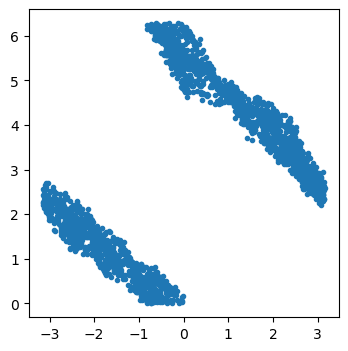

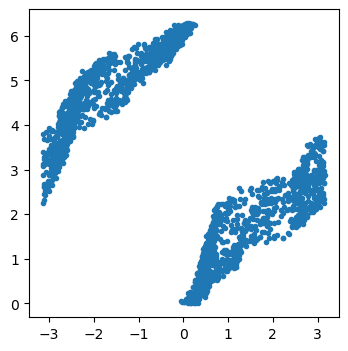

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.ndimage
import sys
from scipy.optimize import minimize
from scipy.special import gammaln
import time
import concurrent.futures
import pickle
import gzip
import plotly
import os

folder_name = 'results/3.7.24_torus/'

# file_name = 'justonetorus_rand17_start_4_estDir' #CHANGED
# file_path = os.path.join(folder_name, file_name)
# with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
#     data = np.load(f, allow_pickle=True)

# estDir4,  params4, llvals4 = data['estDir'],data['params'],data['llvals']

# file_name = 'justonetorus_rand49_start_3_estDir' #CHANGED
# file_path = os.path.join(folder_name, file_name)
# with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
#     data = np.load(f, allow_pickle=True)


# estDir3,  params3, llvals3 = data['estDir'],data['params'],data['llvals']


# file_name = 'justonetorus_rand49_start_2_estDir' #CHANGED
# file_path = os.path.join(folder_name, file_name)
# with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
#     data = np.load(f, allow_pickle=True)


# estDir2, params2, llvals2 = data['estDir'],  data['params'],data['llvals']


# name = 'justonetorus_rand32_start_1_estDir' #CHANGED
# file_path = os.path.join(folder_name, file_name)
# with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
#     data = np.load(f, allow_pickle=True)
# estDir1,  params1, llvals1 = data['estDir'],data['params'],data['llvals']




# #file_name = 'justonetorus_rand35_start_1_estDir_correctangle' #CHANGED
# file_name = 'twocircles_testhybrid_rand49_start_0_estDir'
# file_path = os.path.join(folder_name, file_name)
# with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
#     data = np.load(f, allow_pickle=True)

# #estDir, estDirStd, totnegLogL, params, llvals = data['estDir'], data['estDirStd'],  data['totnegLogL'],data['params'],data['llvals']
# #If not using the final one with fewer values saved:
# estDir0,  params0, llvals0 = data['estDir'],  data['params'],data['llvals']
# print(llvals0)

file_name = 'best_estDir'
#file_name = 'torus_rand16_start_0_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)

#estDir, estDirStd, totnegLogL, params, llvals = data['estDir'], data['estDirStd'],  data['totnegLogL'],data['params'],data['llvals']
#If not using the final one with fewer values saved:
estDir,  params, llvals = data['estDir'],  data['params'],data['llvals']
# print(llvals)



# plt.figure(figsize=(30,30))
# plt.clf()
# estDir = estDir%(2.*np.pi)
# #DDp = (DD+2.*DDstd)
# #DDm = (DD-2.*DDstd)
# for i in range(10):
#     plt.figure
#     si = 2000*i
#     ei = 2000*(i+1)
#     plt.plot(estDir[si:ei,0], '-', color='purple', lw=1)
#     #plt.plot(DDp[si:ei,0], '-', color='blue', lw=0.5)
#     #plt.plot(DDm[si:ei,0], '-', color='blue', lw=0.5)
#     plt.plot(estDir[si:ei,1], '-', color='orange', lw=1)
#     #plt.plot(DDp[si:ei,1], '-', color='red', lw=0.5)
#     #plt.plot(DDm[si:ei,1], '-', color='red', lw=0.5)
#     #plt.plot(headangle[si:ei,0], '-', color='red', lw=1)
#     plt.plot([0,2000], [0, 0], '--', color='black')
#     plt.plot([0,2000], [-np.pi/2., -np.pi/2.], '--', color='black')
#     plt.plot([0,2000], [2.*np.pi, 2.*np.pi], '--', color='black')
#     plt.plot([0,2000], [2.*np.pi+np.pi/2., 2.*np.pi+np.pi/2.], '--', color='black')
# #plt.savefig('%s_lvm_final_decoding.pdf'%(name[:(-4)]))
# print(estDir.shape)


file_name = 'torus' #CHANGED
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)

#Extract data

hd_sim = data['hd_sim_train']
#hd_test = data['']
S = np.array(data['S_train']) #neuron data
print(S.shape, hd_sim.shape)
#print(DD.shape)
print(llvals)
estDir = 
plt.figure(figsize=(4,4))
plt.plot(estDir[:,0], hd_sim[1,:], '.')
#plt.plot(np.transpose(hd_sim)[1:10])

plt.figure(figsize=(4,4))
plt.plot(estDir[:,1], hd_sim[0,:], '.')


(100, 2400) (2, 2400)
[-758735.65188325 -544827.04220651 -527239.76421265 -520167.71719673
 -516730.70758344 -513971.47699042 -513284.63153044 -511558.57875844
 -510714.86840205 -510017.88241305 -509544.42953321 -509055.706626
 -507519.17647317 -507491.08835404 -507737.18077378 -507198.22095332
 -506057.27173433 -504414.78768199 -504128.39808292 -502817.7567036
 -502276.08810347 -500861.18536589 -500149.56770678 -498791.083691
 -498292.09382549 -497847.70302661 -497461.48735228 -496943.45257322
 -494865.35738275 -491792.55228643]


In [17]:
print(estDir.shape,hd_sim.shape)

(2400, 2) (2, 2400)


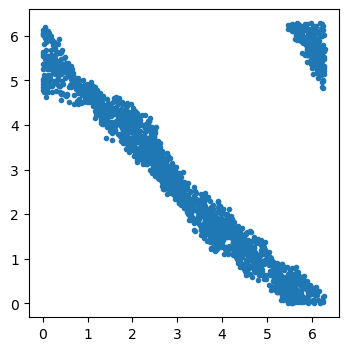

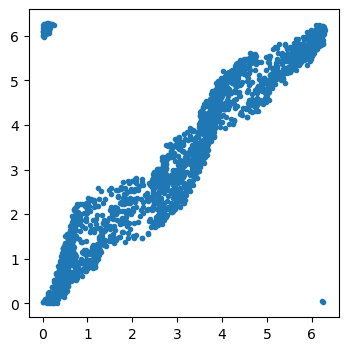

In [27]:
def rotateanglestoalign(DDtry, correctangles):
    def disttotrue(a):
        dd = np.abs(DDtry - hd_sim + a[0])
        dd = np.minimum(dd, 2.*np.pi - dd)
        return np.sum(dd**2)

    # first try without flipping
    result = minimize(disttotrue, [np.pi], method='L-BFGS-B')
    val = result.fun
    offset = result.x[0]

    ## now try flipped
    DDorig = DDtry + 0.
    DDtry = 2.*np.pi - DDtry
    result = minimize(disttotrue, [np.pi], method='L-BFGS-B')
    if result.fun < val:
        return (DDtry + result.x[0]) % (2.*np.pi)
    else:
        return (DDorig + offset) % (2.*np.pi)

def getH(a, D): ## H is the "lambda" for the Poisson random variable
    tc_preftheta = a[0] % (2.*np.pi) # Angles
    tc_prefphi = a[1] % (2.*np.pi)
    tc_beta = a[2] # This is a weight of the gaussian bumb
    tc_h = a[3] # This is background fire rate
    tc_sigma = np.pi/2 ### note, HYPERPARAMETER, also the width of the bumb or variance of the normal dist. 
    if(len(a)>4):
        tc_sigma = a[4]
    distsqrds = ToroidalDist([tc_preftheta, tc_prefphi], D)
    return( tc_h + tc_beta * np.exp(-distsqrds / (2*tc_sigma**2)) )

def ToroidalDist(angles, D):
    D = np.array(D)
    theta = angles[0]
    phi = angles[1]
    #print("tehta, phi, D: ", theta, phi, D)
    
    dx = np.zeros_like(D[:,0])
    dy = np.zeros_like(D[:,0])
    
    for i in range(len(D)):
        dx[i] = abs(D[i, 0] - theta)
        dy[i] = abs(D[i, 1] - phi)
        dx[i] = np.minimum(dx[i], 2 * np.pi - dx[i])
        dy[i] = np.minimum(dy[i], 2 * np.pi - dy[i])
    #print(dx,dy)
    return np.sqrt(dx**2 + dy**2)
    

Text(0.5, 1.0, '2nd angle simulated vs decoded')

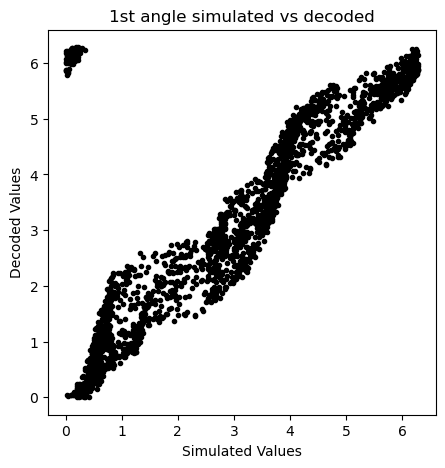

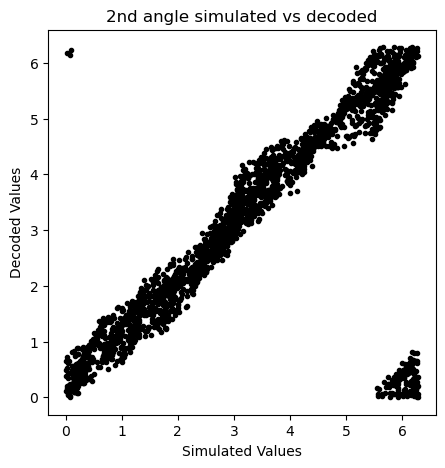

In [28]:


estDir[:,0] = rotateanglestoalign(estDir[:,0], hd_sim[1,:])
estDir[:,1] = rotateanglestoalign(estDir[:,1], hd_sim[0,:])

# estDir0[:,0] = rotateanglestoalign(estDir0[:,0], hd_sim[0,:])
# estDir0[:,1] = rotateanglestoalign(estDir0[:,1], hd_sim[1,:])

# estDir1[:,0] = rotateanglestoalign(estDir1[:,0], hd_sim[0,:])
# estDir1[:,1] = rotateanglestoalign(estDir1[:,1], hd_sim[1,:])

# estDir2[:,0] = rotateanglestoalign(estDir2[:,0], hd_sim[0,:])
# estDir2[:,1] = rotateanglestoalign(estDir2[:,1], hd_sim[1,:])

# estDir3[:,0] = rotateanglestoalign(estDir3[:,0], hd_sim[0,:])
# estDir3[:,1] = rotateanglestoalign(estDir3[:,1], hd_sim[1,:])

# estDir4[:,0] = rotateanglestoalign(estDir4[:,0], hd_sim[0,:])
# estDir4[:,1] = rotateanglestoalign(estDir4[:,1], hd_sim[1,:])


plt.figure(figsize=(5,5))
plt.plot(estDir[:,1], hd_sim[0,:], '.', color = 'black')
plt.xlabel("Simulated Values")  # Label for x-axis
plt.ylabel("Decoded Values")    # Label for y-axis
plt.title("1st angle simulated vs decoded")


plt.figure(figsize=(5,5))
plt.plot(estDir[:,0], hd_sim[1,:], '.', color= 'black' )
plt.xlabel("Simulated Values")  # Label for x-axis
plt.ylabel("Decoded Values")    # Label for y-axis
plt.title("2nd angle simulated vs decoded")



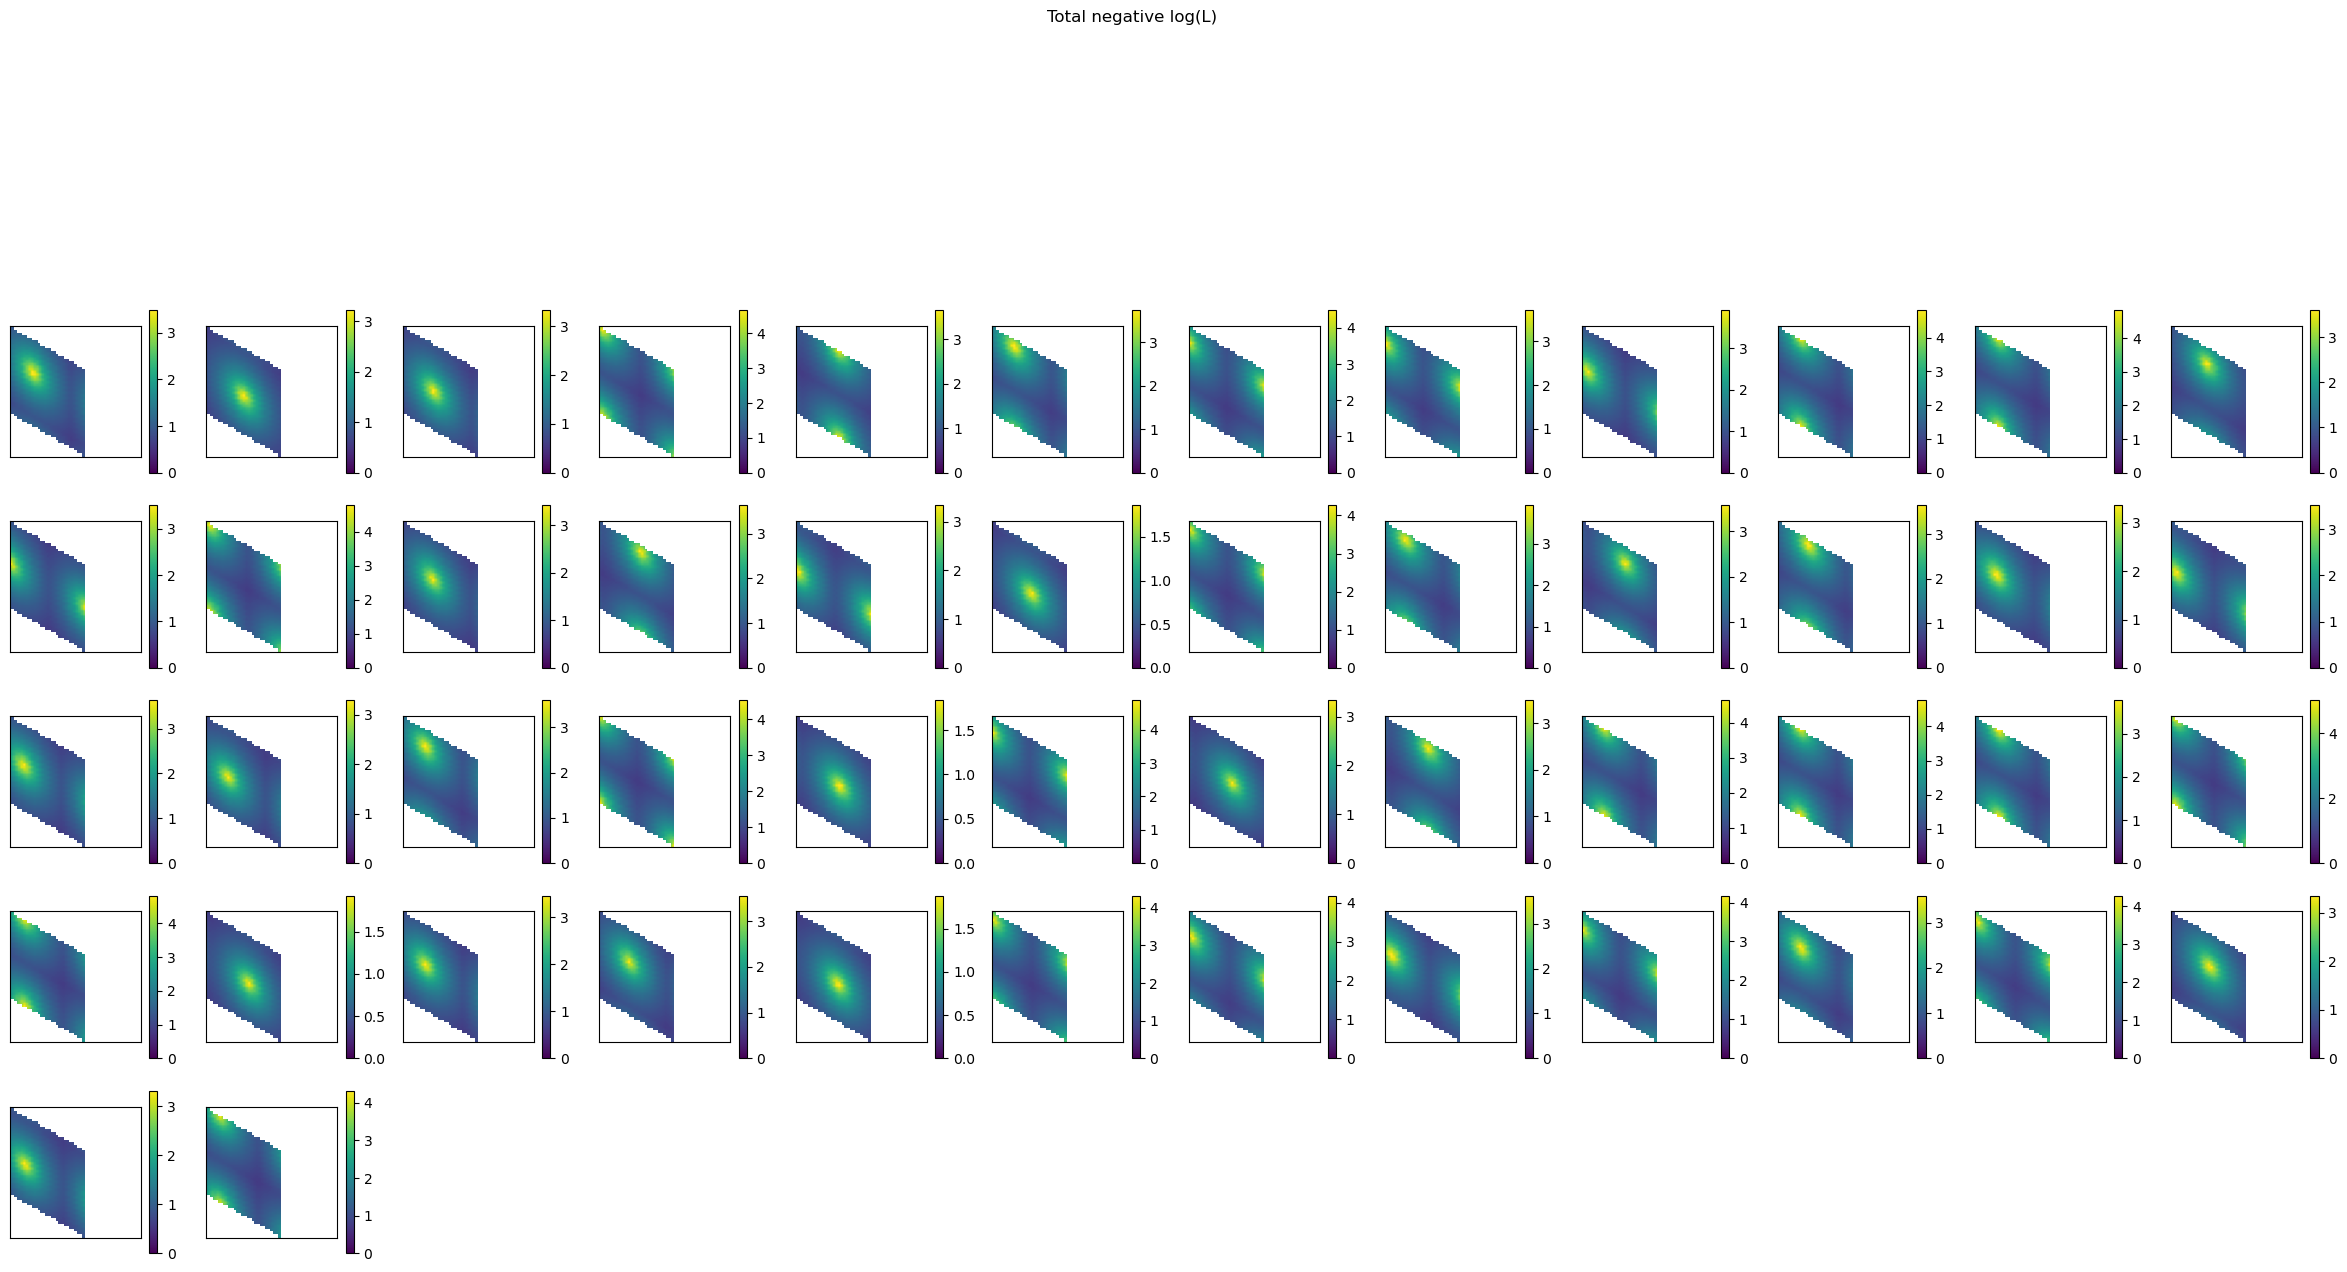

In [21]:
binsize= np.pi/16
N = 2000
if(True):
    fig = plt.figure(2, figsize=(30,30))
    plt.clf()
    size=50
    angs = np.linspace(0, 2.*np.pi, size)
    tangs = np.zeros((size*size, 2))
    for j in range(size):
      for k in range(size):
        tangs[j*size+k, 0] = angs[j]
        tangs[j*size+k, 1] = angs[k]
    xx = tangs[:,0] + 0.5*tangs[:,1]
    yy = np.sqrt(3)*tangs[:,1]/2.# max is 3*np.pi
    for j in range(np.min([N,size])):
      fr = plt.subplot(12,12,j+1)
      ratemapvals = np.exp(getH(params[j,:],tangs))/binsize
      twistrm = np.zeros((size,size))
      twistrm[:] = np.nan
      for k in range(len(xx)):
        ki = np.min([size-1, int(size*xx[k]/(3.*np.pi))])
        kj = np.min([size-1, int(size*yy[k]/(3.*np.pi))])
        twistrm[ki,kj] = ratemapvals[k]
      plt.imshow(twistrm, vmin=0.)
      plt.colorbar()
      fr.axes.get_xaxis().set_visible(False)
      fr.axes.get_yaxis().set_visible(False)
    fig.suptitle('Total negative log(L) ')


In [22]:
import plotly.graph_objects as go
import numpy as np

# Create grid values for theta and phi
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

# Parametric equations for the torus with R = r = 1
x = (1 + np.cos(theta)) * np.cos(phi)
y = (1 + np.cos(theta)) * np.sin(phi)
z = np.sin(theta)

# Create the figure for the torus
fig = go.Figure(data=[
    go.Surface(
        x=x, y=y, z=z,
        showscale=False,
        colorscale=['grey','grey'],  # Sets the color to grey
        opacity=0.5  # Makes the torus translucent
    )
])

# Add points to the plot (replace these with your specific points)
# Example points:
#points_theta = np.array([np.pi/4, np.pi/2, 3*np.pi/4])
points_theta_sim = np.array(hd_sim[0,:])
points_phi_sim = np.array(hd_sim[1,:])

points_theta_res = np.array(estDir[:,0])
points_phi_res = np.array(estDir[:,1])

#points_theta_res1 = np.array(estDir1[5:10,0])
#points_phi_res1 = np.array(estDir1[5:10,1])


points_x = (1 + np.cos(points_theta_sim)) * np.cos(points_phi_sim)
points_y = (1 + np.cos(points_theta_sim)) * np.sin(points_phi_sim)
points_z = np.sin(points_theta_sim)

# points_x1 = (1 + np.cos(points_theta_res1)) * np.cos(points_phi_res1)
# points_y1 = (1 + np.cos(points_theta_res1)) * np.sin(points_phi_res1)
# points_z1 = np.sin(points_theta_res1)

points_x2 = (1 + np.cos(points_theta_res)) * np.cos(points_phi_res)
points_y2 = (1 + np.cos(points_theta_res)) * np.sin(points_phi_res)
points_z2 = np.sin(points_theta_res)

# Add the points to the figure
fig.add_trace(go.Scatter3d(x=points_x, y=points_y, z=points_z,
                           mode='markers', marker=dict(color='red'), name = "sim data")) # Original simulated data
fig.add_trace(go.Scatter3d(x=points_x2, y=points_y2, z=points_z2,
                           mode='markers', marker=dict(color='blue'), name="final iteration")) # after last interation
# Update the layout
fig.update_layout(
    title='3D Torus with Colored Points',
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Show the figure

fig.show()


In [23]:
def simpleToroidalDist(a, b):
    theta_a = a[0]
    phi_a = a[1]
    theta_b = b[0]
    phi_b = b[1]
    #print("tehta, phi, D: ", theta, phi, D)

    dx = abs(theta_a - theta_b)
    dy = abs(phi_a - phi_b)
    dx = np.minimum(dx, 2 * np.pi - dx)
    dy = np.minimum(dy, 2 * np.pi - dy)
    #print(dx,dy)
    return np.sqrt(dx**2 + dy**2), dx, dy

def totalToroidalDist(estDir, hd_sim):
    dist = 0
    dx=0
    dy=0
    for i in range(len(estDir[:,0])):
        dist_temp, dx_temp, dy_temp = simpleToroidalDist(estDir[i,:],hd_sim[:,i])
        dist += dist_temp
        dx += dx_temp
        aveX = dx/N
        dy += dy_temp
        aveY = dy/N
    return dist, aveX, aveY

totDist, aveX, aveY =totalToroidalDist(estDir,hd_sim)
print(totDist, aveX, aveY)

print((totDist/(np.sqrt(2)*N)))

totDist0, aveX0, aveY0 =totalToroidalDist(estDir,hd_sim)
print(totDist0, aveX0, aveY0)

print((totDist0/(np.sqrt(2)*N)))



997.7332598117016 0.26595811312693357 0.3786856644850608
0.3527519769141068
997.7332598117016 0.26595811312693357 0.3786856644850608
0.3527519769141068


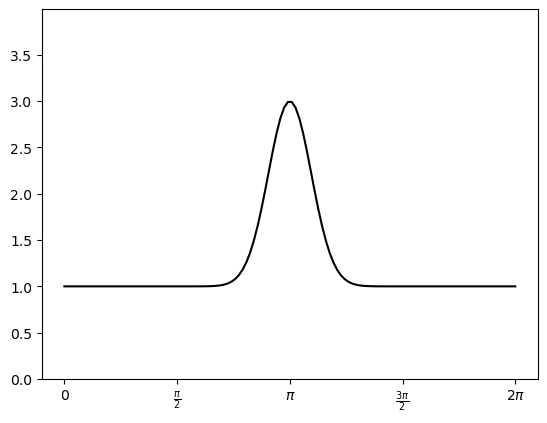

In [24]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.pi
standard_deviation = 0.3
x_values = np.linspace(0, 2*np.pi, 120)
y_values = 2*np.exp(-0.5 * ((x_values - mean) / standard_deviation) ** 2)

# Raise the bottom line above zero
offset = 1  # Adjust this value to raise or lower the bottom line
y_values += offset

# Plotting the Gaussian curve
plt.plot(x_values, y_values, color='black')

# Setting the x-axis to show 0, pi/2, pi, 3*pi/2, 2*pi
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

plt.ylim(0, max(y_values) + 1)  # Adjust y-axis limit

plt.show()

In [27]:



#0
file_name = 'twocircles_testhybrid_rand49_start_0_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir0, params0, llvals0 = data['estDir'], data['params'], data['llvals']
#1
file_name = 'twocircles_testhybrid_rand49_start_1_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir1, params1, llvals1 = data['estDir'], data['params'], data['llvals']
#2
file_name = 'twocircles_testhybrid_rand19_start_2_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir2, params2, llvals2 = data['estDir'], data['params'], data['llvals']
#3
file_name = 'twocircles_testhybrid_rand49_start_3_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir3, params3, llvals3 = data['estDir'], data['params'], data['llvals']
#4
file_name = 'twocircles_testhybrid_rand49_start_4_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir4, params4, llvals4 = data['estDir'], data['params'], data['llvals']
# #5
file_name = 'twocircles_testhybrid_rand49_start_5_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir5, params5, llvals5 = data['estDir'], data['params'], data['llvals']
#6
file_name = 'twocircles_testhybrid_rand49_start_6_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir6, params6, llvals6 = data['estDir'], data['params'], data['llvals']
#7
file_name = 'twocircles_testhybrid_rand49_start_7_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir7, params7, llvals7 = data['estDir'], data['params'], data['llvals']
#8
file_name = 'twocircles_testhybrid_rand49_start_8_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir8, params8, llvals8 = data['estDir'], data['params'], data['llvals']
#9
file_name = 'twocircles_testhybrid_rand8_start_9_estDir'
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)
estDir9, params9, llvals9 = data['estDir'], data['params'], data['llvals']


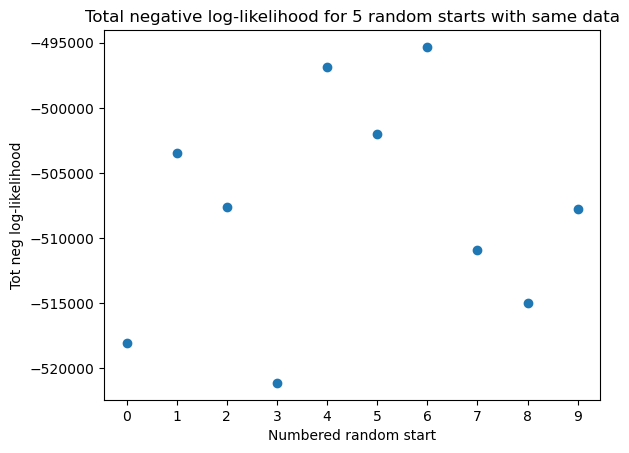

In [30]:
llvals_values = []
indices = []

for i in range(10):
    llvals = locals()[f'llvals{i}']
    llvals_values.append(llvals)  # Add the llvals value
    indices.append(i)  # Corresponding index

# Create a scatter plot
plt.scatter(indices, llvals_values)
plt.title('Total negative log-likelihood for 5 random starts with same data')
plt.xlabel('Numbered random start')
plt.ylabel('Tot neg log-likelihood')
plt.xticks(range(10))  # Set x-ticks to be the file indices
plt.show()

In [ ]:
def predict(params, testI):
    hd_test = ...
    return hd_test

def test_error(hd_test, est_Dir):
    #Compute geodesic error
    error = ...
    return error

def getpreddir(params, P=N, NX=3):
            def getlikelihood(Dtry):
                logl = np.zeros(T)
                for i in range(N):
                    H = getH(params[i,:], Dtry)
                    logl += (S[i,:]*H - np.exp(H) - gammaln(S[i,:]+1))
                #logl= logl/N
                #output_file.write("np.exp(logl) returned from getlikelihoods: "+ str(np.exp(logl))+ "\n")
                return(np.exp(logl)) 

            
            T = S.shape[1]  # Number of time steps based on provided length of data S
            particles = np.random.uniform(0, 20*np.pi, size=(P, T, 2)) % (2.*np.pi)
            Dc = np.zeros((T, 2))
            Dcstd = np.zeros(T)

            for xxx in range(NX):
                particles = particles + np.random.normal(0, np.pi/4, size=(P, T, 2))
                particles %= (2*np.pi)

                likelihoods = np.zeros((P, T))
                for i in range(P):
                    Dt = particles[i,:,:]
                    likelihoods[i,:] = getlikelihood(Dt)
                #output_file.write(str(np.exp(likelihoods)))
                #likelihoods = np.exp(likelihoods)
                normfact = np.sum(likelihoods, axis=0)
                #normfact[normfact == 0] = 1  # Avoid division by zero
                weights = likelihoods / normfact[np.newaxis, :]
      
                for t in range(T):
                    inds = np.random.choice(np.arange(P), size=P, p=weights[:,t])
                    particles[:,t,:] = particles[inds,t,:]
                    if(xxx == NX-1):  
                        angs = particles[:,t,:] + 0.
                        Dc[t,:], Dcstd[t] = meanandstd(angs)
            return(Dc, Dcstd)